<a href="https://colab.research.google.com/github/bananighosh/Fall-2023-NYU-AI/blob/main/assignment_2/Part2/bg2502_using_convnets_with_small_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pantelis/aiml-common/blob/master/lectures/cnn/cnn-example-architectures/using_convnets_with_small_datasets.ipynb)


[NOTE]: Kindly open in collab and follow the **Table of Contents** for easier navigation through this notebook implemented by Banani Ghosh[bg2502]

This notebook is by F. Chollet and is included in his book.

In [ ]:
# import os
# os.environ['LD_LIBRARY_PATH'] = '/workspaces/artificial_intelligence/.venv/lib/python3.11/site-packages/tensorrt_libs'

import tensorflow as tf
import keras
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

# Using convnets with small datasets

This notebook contains the code sample found in Chapter 5, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on
classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000
pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We
will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be
achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce
*data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve
our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction
with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to
our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a
pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer
vision with small datasets.

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can
potentially suffice if the model is small and well-regularized and if the task is simple.
Because convnets learn local, translation-invariant features, they are very
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at:
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our
models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading
and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [ ]:
import os, shutil

In [ ]:
# Unzip file
!mkdir -p dogscats/subset
!unzip -o -q dogs-vs-cats-subset.zip -d dogscats


In [ ]:
base_dir = 'dogscats/subset'
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(base_dir, 'train', 'cats')
train_dogs_dir = os.path.join(base_dir, 'train', 'dogs')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate
measure of success.

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to
use in various situations).

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we
will use here.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop
at some point.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does.
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case,
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument,
which tells the process how many batches to draw from the validation generator for evaluation.

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30


<ipython-input-16-a7acfc8093a4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 18s 62ms/step - loss: 0.7091 - acc: 0.5290 - val_loss: 0.6919 - val_acc: 0.5710
Epoch 2/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6950 - acc: 0.5350 - val_loss: 0.6740 - val_acc: 0.5860
Epoch 3/30
100/100 [==============================] - 6s 58ms/step - loss: 0.6723 - acc: 0.5985 - val_loss: 0.6669 - val_acc: 0.5780
Epoch 4/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6470 - acc: 0.6175 - val_loss: 0.6373 - val_acc: 0.6250
Epoch 5/30
100/100 [==============================] - 6s 61ms/step - loss: 0.6056 - acc: 0.6675 - val_loss: 0.5872 - val_acc: 0.6960
Epoch 6/30
100/100 [==============================] - 5s 52ms/step - loss: 0.5828 - acc: 0.6975 - val_loss: 0.5726 - val_acc: 0.6740
Epoch 7/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5401 - acc: 0.7250 - val_loss: 0.6396 - val_acc: 0.6850
Epoch 8/30
100/100 [==============================] - 6s 60ms/step - loss: 0.49

It is good practice to always save your models after training:

In [ ]:
model.save('cats_and_dogs_small_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Let's plot the loss and accuracy of the model over the training and validation data during training:

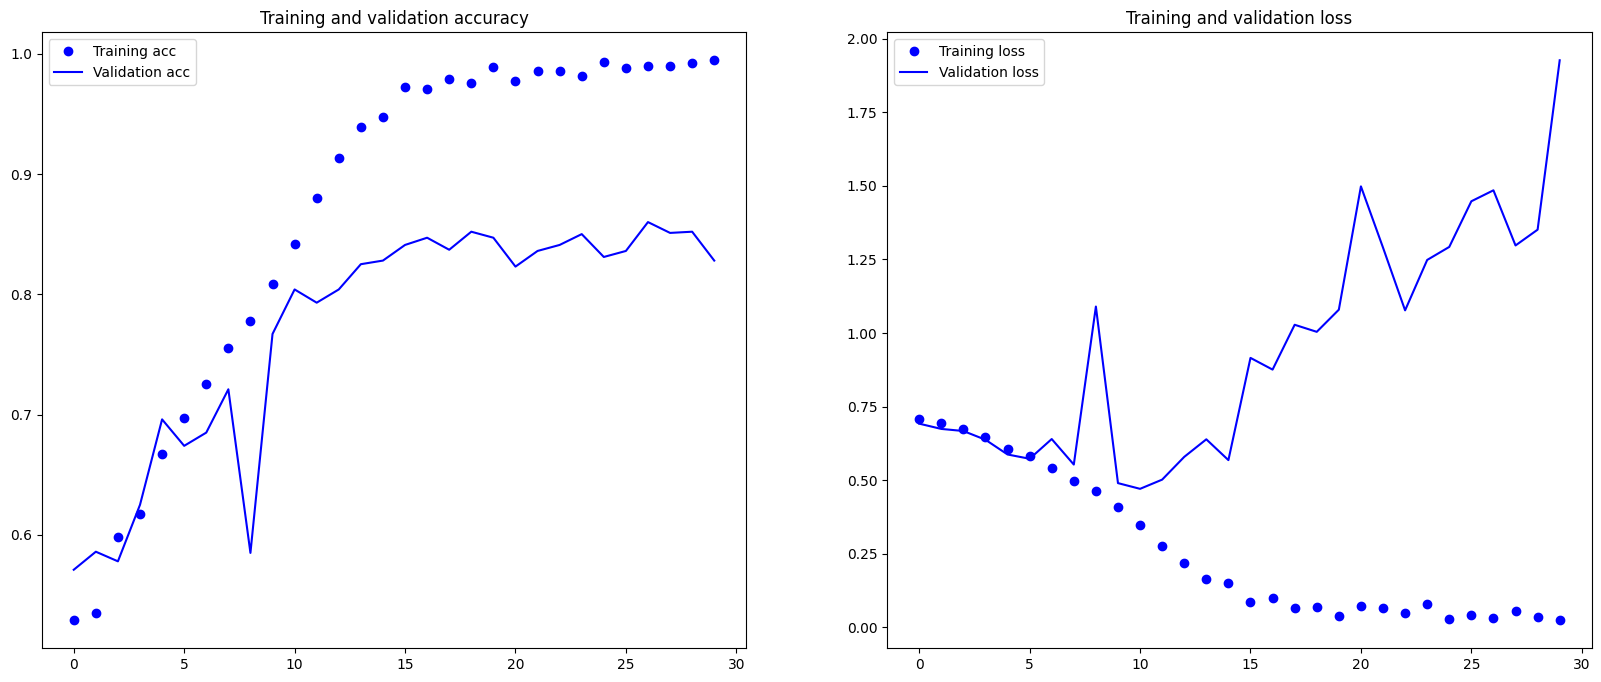

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data
augmentation*.

### Plot the ROC curves

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [ ]:
def find_labels_and_probability(img_gen):
  y_true = img_gen.classes

  # Get predicted probabilities (y_score)
  y_pred = model.predict(img_gen)

  return y_true, y_pred

# train_y_true, train_probs = find_labels_and_probability(train_generator)
# val_y_true, val_probs = find_labels_and_probability(validation_generator)
test_y_true, test_probs = find_labels_and_probability(test_generator)

32/32 [==============================] - 2s 50ms/step


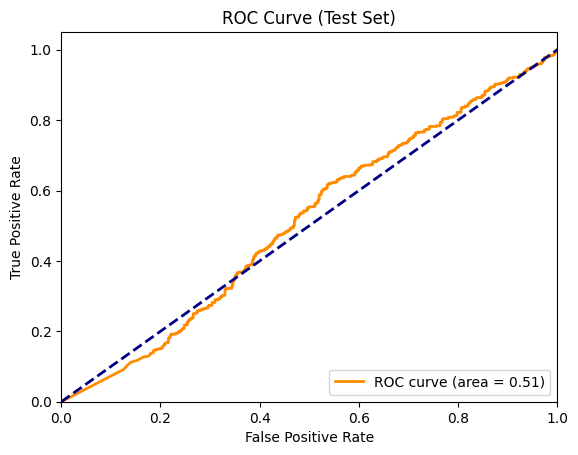

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curves for training, validation, and test sets
# plot_roc_curve(train_y_true, train_probs, title='ROC Curve (Training Set)')
# plot_roc_curve(val_y_true, val_probs, title='ROC Curve (Validation Set)')
plot_roc_curve(test_y_true, test_probs, title='ROC Curve (Test Set)')

### Plot the Recall-Precision curves

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
# Compute precision and recall for each dataset
# train_precision, train_recall, threshold = precision_recall_curve(train_y_true, train_probs)
# val_precision, val_recall, threshold = precision_recall_curve(val_y_true, val_probs)
test_precision, test_recall, threshold = precision_recall_curve(test_y_true, test_probs)

# Compute average precision (AUC-PR) for each dataset
# train_average_precision = average_precision_score(train_y_true, train_probs)
# val_average_precision = average_precision_score(val_y_true, val_probs)
test_average_precision = average_precision_score(test_y_true, test_probs)

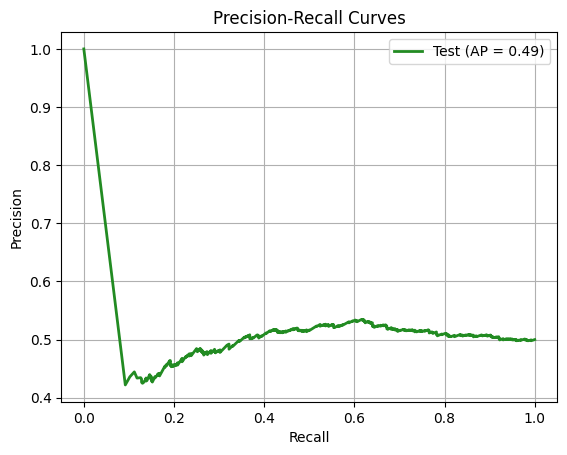

In [ ]:
# Plot Precision-Recall curves for all datasets
plt.figure()
# plt.plot(train_recall, train_precision, color='darkorange', lw=2, label=f'Training (AP = {train_average_precision:.2f})')
# plt.plot(val_recall, val_precision, color='royalblue', lw=2, label=f'Validation (AP = {val_average_precision:.2f})')
plt.plot(test_recall, test_precision, color='forestgreen', lw=2, label=f'Test (AP = {test_average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Confusion matrix for 50% threshold

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Confusion Matrix Test Data (Threshold = 50%):
[[302 198]
 [289 211]]


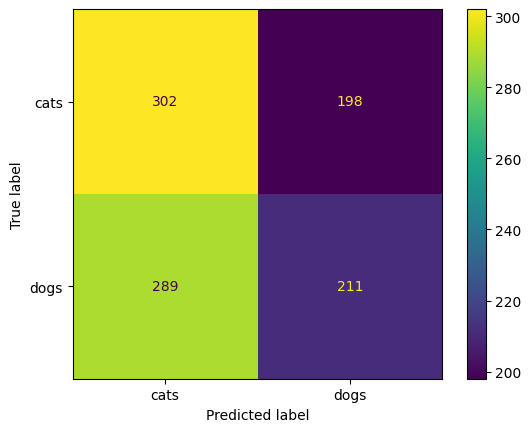

In [ ]:
def find_labels_and_probability(y_true, y_probs):
  threshold = 0.5
  # Convert probabilities to binary classes using the 50% threshold
  y_pred = (y_probs >= threshold).astype(int)  # Predicted classes (0 or 1)

  # Create the confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  return conf_matrix

# val_conf_matrix = find_labels_and_probability(val_y_true, val_probs)
test_conf_matrix = find_labels_and_probability(test_y_true, test_probs)

# Print the confusion matrix
print("Confusion Matrix Test Data (Threshold = 50%):")
print(test_conf_matrix)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=test_generator.class_indices)
disp.plot(cmap='viridis', values_format='d')

# print("Confusion Matrix Validation Data (Threshold = 50%):")
# print(val_conf_matrix)

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data.
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator`
instance. Let's get started with an example:

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

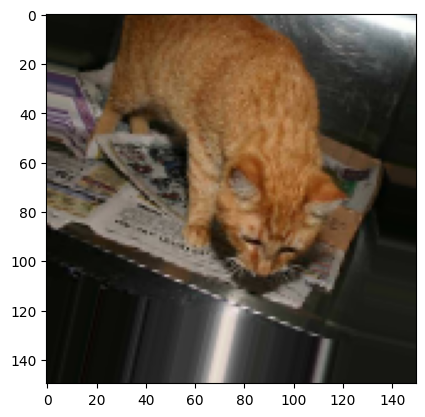

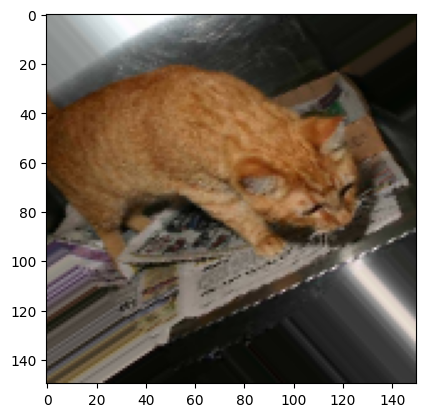

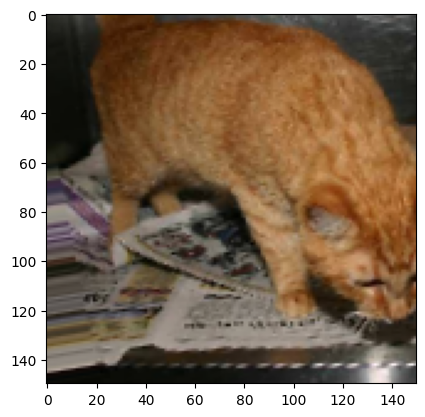

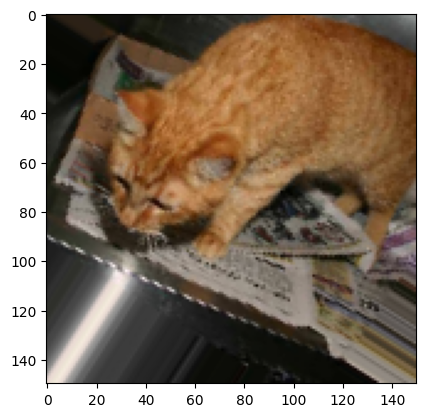

In [ ]:
# This is module with image preprocessing utilities
import keras.utils as image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information,
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
62/62 [==============================] - 19s 248ms/step - loss: 0.6998 - acc: 0.4924 - val_loss: 0.6924 - val_acc: 0.5192
Epoch 2/100
62/62 [==============================] - 16s 261ms/step - loss: 0.6962 - acc: 0.5391 - val_loss: 0.6895 - val_acc: 0.5081
Epoch 3/100
62/62 [==============================] - 16s 260ms/step - loss: 0.6809 - acc: 0.5772 - val_loss: 0.6757 - val_acc: 0.5554
Epoch 4/100
62/62 [==============================] - 16s 260ms/step - loss: 0.6880 - acc: 0.5777 - val_loss: 0.6665 - val_acc: 0.5998
Epoch 5/100
62/62 [==============================] - 30s 485ms/step - loss: 0.6656 - acc: 0.5899 - val_loss: 0.6563 - val_acc: 0.5897
Epoch 6/100
62/62 [==============================] - 15s 249ms/step - loss: 0.6540 - acc: 0.6098 - val_loss: 0.7147 - val_acc: 0.5433
Epoch 7/100
62/62 [==============================] - 16s 259ms/step - loss: 0.6606 - acc: 0.6098 - val_loss: 0.6

Let's save our model -- we will be using it in the section on convnet visualization.

In [ ]:
model.save('cats_and_dogs_small_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Let's plot our results again:

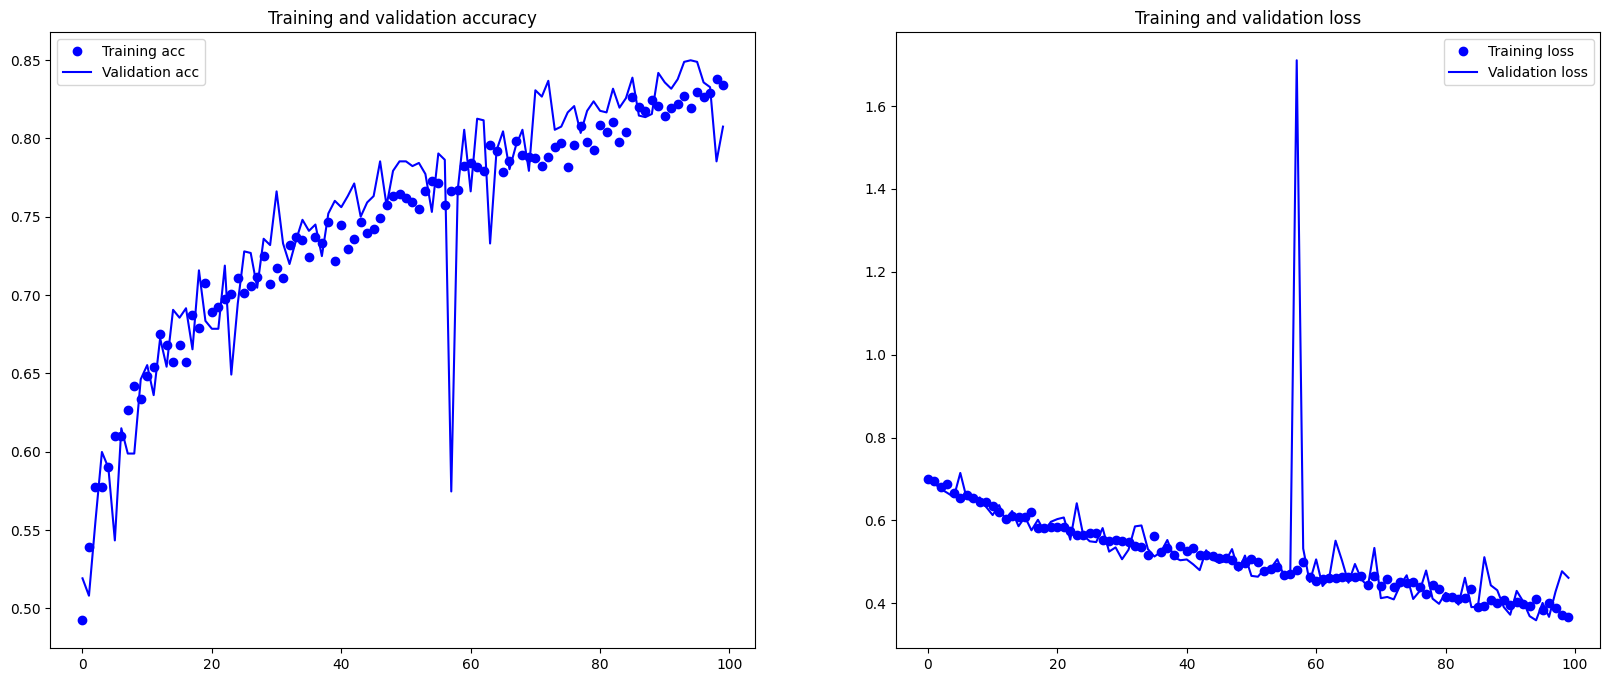

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize= (20,8))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two
sections.


### Plot the ROC curves

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [ ]:
def find_labels_and_probability(img_gen):
  y_true = img_gen.classes

  # Get predicted probabilities (y_score)
  y_pred = model.predict(img_gen)

  return y_true, y_pred

# train_y_true, train_probs = find_labels_and_probability(train_generator)
# val_y_true, val_probs = find_labels_and_probability(validation_generator)
test_y_true, test_probs = find_labels_and_probability(test_generator)

32/32 [==============================] - 2s 48ms/step


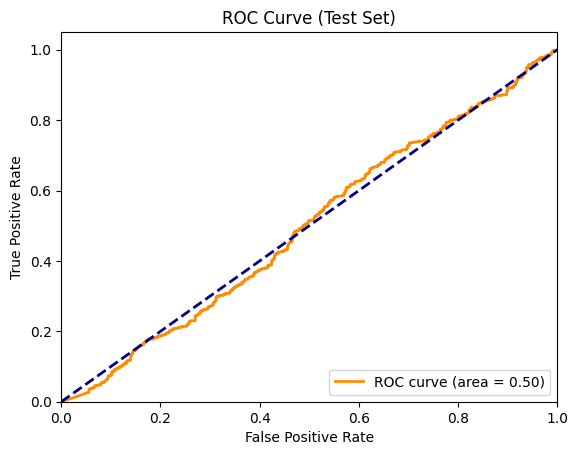

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curves for training, validation, and test sets
# plot_roc_curve(train_y_true, train_probs, title='ROC Curve (Training Set)')
# plot_roc_curve(val_y_true, val_probs, title='ROC Curve (Validation Set)')
plot_roc_curve(test_y_true, test_probs, title='ROC Curve (Test Set)')

### Plot the Recall-Precision curves

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
# Compute precision and recall for each dataset
# train_precision, train_recall, threshold = precision_recall_curve(train_y_true, train_probs)
# val_precision, val_recall, threshold = precision_recall_curve(val_y_true, val_probs)
test_precision, test_recall, threshold = precision_recall_curve(test_y_true, test_probs)

# Compute average precision (AUC-PR) for each dataset
# train_average_precision = average_precision_score(train_y_true, train_probs)
# val_average_precision = average_precision_score(val_y_true, val_probs)
test_average_precision = average_precision_score(test_y_true, test_probs)

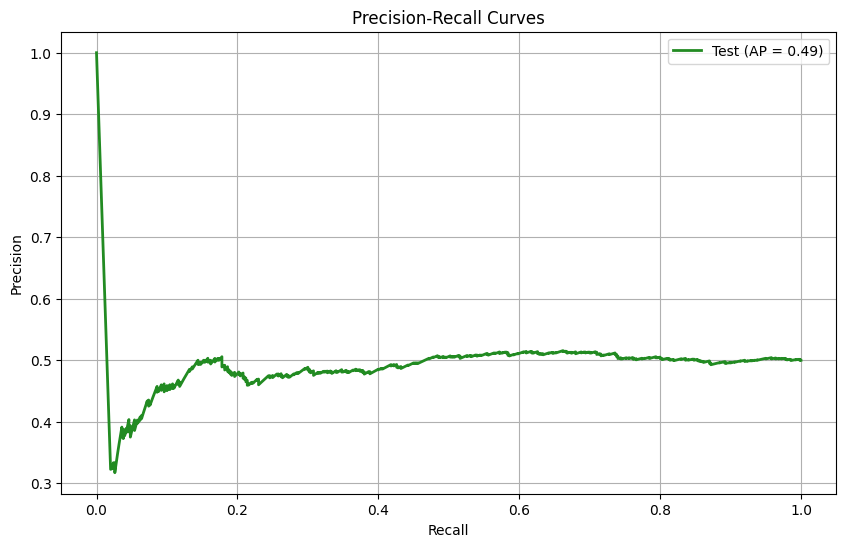

In [ ]:
# Plot Precision-Recall curves for all datasets
plt.figure(figsize=(10, 6))
# plt.plot(train_recall, train_precision, color='darkorange', lw=2, label=f'Training (AP = {train_average_precision:.2f})')
# plt.plot(val_recall, val_precision, color='royalblue', lw=2, label=f'Validation (AP = {val_average_precision:.2f})')
plt.plot(test_recall, test_precision, color='forestgreen', lw=2, label=f'Test (AP = {test_average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Confusion matrix for 50% threshold

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Confusion Matrix Test Data (Threshold = 50%):
[[200 300]
 [186 314]]


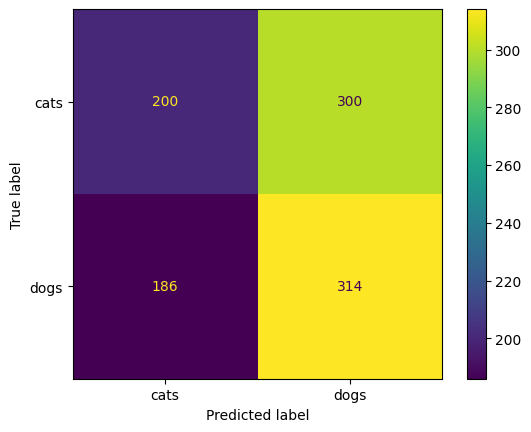

In [ ]:
def find_labels_and_probability(y_true, y_probs):
  threshold = 0.5
  # Convert probabilities to binary classes using the 50% threshold
  y_pred = (y_probs >= threshold).astype(int)  # Predicted classes (0 or 1)

  # Create the confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  return conf_matrix

# val_conf_matrix = find_labels_and_probability(val_y_true, val_probs)
test_conf_matrix = find_labels_and_probability(test_y_true, test_probs)

# Print the confusion matrix
print("Confusion Matrix Test Data (Threshold = 50%):")
print(test_conf_matrix)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=test_generator.class_indices)
disp.plot(cmap='viridis', values_format='d')

# print("Confusion Matrix Validation Data (Threshold = 50%):")
# print(val_conf_matrix)

## Optuna to find the best hyperparameters


In [ ]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


In [ ]:
import optuna

### tune model with hyperparameters

In [ ]:
def build_cnn_dog_cat_model(learning_rate, num_filters,
                              dropout_rate, batch_size):
  model = keras.Sequential()

  model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(num_filters * 2, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(num_filters * 4, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(num_filters * 4, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  # if optimizer_name == 'rmsprop':
  #           optimizer = optimizers.RMSprop(lr=learning_rate)
  # elif optimizer_name == 'adam':
  #         optimizer = optimizers.Adam(learning_rate=learning_rate)
  # elif optimizer_name == 'sgd':
  #         optimizer = optimizers.SGD(learning_rate=learning_rate, nesterov=True)
  # else:
  #     raise ValueError("Invalid optimizer name")

  model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=learning_rate),
                metrics=['acc'])

  # model.compile(loss='binary_crossentropy',
  #                 optimizer=optimizer,
  #                 metrics=['acc'])

  return model

### define the objective function

In [ ]:
def objective(trial):
  # Define hyperparameters to optimize
  # optimizer_name = trial.suggest_categorical('optimizer', ['rmsprop', 'adam', 'sgd' ])
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
  num_filters = trial.suggest_int('num_filters', 32, 256)
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
  batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
  rotation_range = trial.suggest_int('rotation_range', 0, 180)
  width_shift_range = trial.suggest_float('width_shift_range', 0.0, 1.0)
  height_shift_range = trial.suggest_float('height_shift_range', 0.0, 1.0)
  shear_range = trial.suggest_float('shear_range', 0.0, 1.0)
  zoom_range = trial.suggest_float('zoom_range', 0.0, 1.0)
  horizontal_flip = trial.suggest_categorical('horizontal_flip', [True, False])

  train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
  )

  train_generator = train_datagen.flow_from_directory(
          # This is the target directory
          train_dir,
          # All images will be resized to 150x150
          target_size=(150, 150),
          batch_size=batch_size,
          # Since we use binary_crossentropy loss, we need binary labels
          class_mode='binary')

  validation_generator = validation_datagen.flow_from_directory(
          validation_dir,
          target_size=(150, 150),
          batch_size=batch_size,
          class_mode='binary')

  model_optuna = build_cnn_dog_cat_model(learning_rate, num_filters, dropout_rate, batch_size)

  history = model_optuna.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size)

  # Evaluate the model on the validation set
  val_loss, val_acc = model.evaluate(validation_generator, steps=len(validation_generator))

  # Return the validation accuracy as the objective to optimize
  return val_acc

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)  # You can adjust the number of trials

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2023-10-09 04:00:37,356] A new study created in memory with name: no-name-d87da641-e89b-4d4f-a8f5-8471973e6cf2


Found 2000 images belonging to 2 classes.


<ipython-input-51-2d5146648bdb>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-51-2d5146648bdb>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Found 1000 images belonging to 2 classes.


Epoch 1/20
125/125 [==============================] - 43s 249ms/step - loss: 0.7035 - acc: 0.4980 - val_loss: 0.6931 - val_acc: 0.5020
Epoch 2/20
125/125 [==============================] - 20s 163ms/step - loss: 0.6939 - acc: 0.5085 - val_loss: 0.6923 - val_acc: 0.5101
Epoch 3/20
125/125 [==============================] - 18s 145ms/step - loss: 0.6930 - acc: 0.5400 - val_loss: 0.6916 - val_acc: 0.5010
Epoch 4/20
125/125 [==============================] - 19s 155ms/step - loss: 0.6954 - acc: 0.5345 - val_loss: 0.6840 - val_acc: 0.5625
Epoch 5/20
125/125 [==============================] - 19s 147ms/step - loss: 0.6947 - acc: 0.5500 - val_loss: 0.6816 - val_acc: 0.5655
Epoch 6/20
125/125 [==============================] - 20s 158ms/step - loss: 0.6882 - acc: 0.5695 - val_loss: 0.6861 - val_acc: 0.5585
Epoch 7/20
125/125 [==============================] - 19s 151ms/step - loss: 0.6885 - acc: 0.5615 - val_loss: 0.6758 - val_acc: 0.5696
Epoch 8/20
125/125 [==============================] - 2

[I 2023-10-09 04:09:48,733] Trial 0 finished with value: 0.8069999814033508 and parameters: {'learning_rate': 0.0001301956476225021, 'num_filters': 122, 'dropout_rate': 0.40332556704914646, 'batch_size': 16, 'rotation_range': 164, 'width_shift_range': 0.4711457168062444, 'height_shift_range': 0.5650464421060059, 'shear_range': 0.7091916436488243, 'zoom_range': 0.626790424124882, 'horizontal_flip': False}. Best is trial 0 with value: 0.8069999814033508.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Epoch 1/20
31/31 [==============================] - 31s 635ms/step - loss: 0.6974 - acc: 0.5026 - val_loss: 0.6926 - val_acc: 0.5052
Epoch 2/20
31/31 [==============================] - 29s 884ms/step - loss: 0.6936 - acc: 0.5181 - val_loss: 0.6945 - val_acc: 0.4938
Epoch 3/20
31/31 [==============================] - 23s 704ms/step - loss: 0.6952 - acc: 0.4969 - val_loss: 0.6929 - val_acc: 0.5063
Epoch 4/20
31/31 [==============================] - 19s 610ms/step - loss: 0.6934 - acc: 0.4979 - val_loss: 0.6927 - val_acc: 0.5063
Epoch 5/20
31/31 [==============================] - 19s 606ms/step - loss: 0.6938 - acc: 0.4824 - val_loss: 0.6917 - val_acc: 0.5312
Epoch 6/20
31/31 [==============================] - 26s 834ms/step - loss: 0.6920 - acc: 0.5217 - val_loss: 0.6926 - val_acc: 0.5031
Epoch 7/20
31/31 [==============================] - 21s 657ms/step - loss: 0.6958 - acc: 0.5486 - val_loss: 0.6866 - val_acc: 0.5813
Epoch 8/20
31/31 [==============================] - 21s 656ms/step - 

[I 2023-10-09 04:18:38,887] Trial 1 finished with value: 0.8069999814033508 and parameters: {'learning_rate': 0.005526225298297534, 'num_filters': 112, 'dropout_rate': 0.16366027603344935, 'batch_size': 64, 'rotation_range': 3, 'width_shift_range': 0.8135198800366643, 'height_shift_range': 0.40614169317451276, 'shear_range': 0.8646171783728398, 'zoom_range': 0.37871191758122347, 'horizontal_flip': False}. Best is trial 0 with value: 0.8069999814033508.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Epoch 1/20
125/125 [==============================] - 23s 154ms/step - loss: 0.7042 - acc: 0.4965 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/20
125/125 [==============================] - 19s 154ms/step - loss: 0.6933 - acc: 0.5010 - val_loss: 0.6942 - val_acc: 0.4960
Epoch 3/20
125/125 [==============================] - 20s 156ms/step - loss: 0.6925 - acc: 0.5390 - val_loss: 0.6850 - val_acc: 0.5444
Epoch 4/20
125/125 [==============================] - 19s 155ms/step - loss: 0.6904 - acc: 0.5505 - val_loss: 0.6900 - val_acc: 0.5192
Epoch 5/20
125/125 [==============================] - 20s 157ms/step - loss: 0.6910 - acc: 0.5760 - val_loss: 0.6781 - val_acc: 0.5544
Epoch 6/20
125/125 [==============================] - 19s 150ms/step - loss: 0.6838 - acc: 0.5715 - val_loss: 0.6667 - val_acc: 0.5726
Epoch 7/20
125/125 [==============================] - 20s 156ms/step - loss: 0.6771 - acc: 0.5810 - val_loss: 0.7212 - val_acc: 0.5060
Epoch 8/20
125/125 [==============================] - 1

[I 2023-10-09 04:25:54,182] Trial 2 finished with value: 0.8069999814033508 and parameters: {'learning_rate': 0.0011184113733061457, 'num_filters': 114, 'dropout_rate': 0.02419759609792682, 'batch_size': 16, 'rotation_range': 23, 'width_shift_range': 0.16926657797401556, 'height_shift_range': 0.9648470210299581, 'shear_range': 0.0019223956238895168, 'zoom_range': 0.10601085343362138, 'horizontal_flip': True}. Best is trial 0 with value: 0.8069999814033508.


Best Hyperparameters: {'learning_rate': 0.0001301956476225021, 'num_filters': 122, 'dropout_rate': 0.40332556704914646, 'batch_size': 16, 'rotation_range': 164, 'width_shift_range': 0.4711457168062444, 'height_shift_range': 0.5650464421060059, 'shear_range': 0.7091916436488243, 'zoom_range': 0.626790424124882, 'horizontal_flip': False}


In [ ]:
# Get the best trial and hyperparameters
best_trial = study.best_trial
# best_optimizer = best_trial.params['optimizer']
best_learning_rate = best_trial.params['learning_rate']
best_num_filters = best_trial.params['num_filters']
best_dropout_rate = best_trial.params['dropout_rate']
best_batch_size = best_trial.params['batch_size']

best_rotation_range = best_trial.params['rotation_range']
best_width_shift_range = best_trial.params['width_shift_range']
best_height_shift_range = best_trial.params['height_shift_range']
best_shear_range = best_trial.params['shear_range']
best_zoom_range = best_trial.params['zoom_range']
best_horizontal_flip = best_trial.params['horizontal_flip']


# Define the best hyperparameters here
best_params = study.best_params
# print("Best Hyperparameters:", best_params)
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

Best Hyperparameters: {'learning_rate': 0.0001301956476225021, 'num_filters': 122, 'dropout_rate': 0.40332556704914646, 'batch_size': 16, 'rotation_range': 164, 'width_shift_range': 0.4711457168062444, 'height_shift_range': 0.5650464421060059, 'shear_range': 0.7091916436488243, 'zoom_range': 0.626790424124882, 'horizontal_flip': False}


### Build the Best model

In [ ]:
best_model = build_cnn_dog_cat_model(best_learning_rate, best_num_filters, best_dropout_rate, best_batch_size)

In [ ]:
model.save('cats_and_dogs_best_tuned_model_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Data Augmentation with the best hyperparameters

In [ ]:
train_datagen_tuned = ImageDataGenerator(
    rescale=1./255,
    rotation_range=best_rotation_range,
    width_shift_range=best_width_shift_range,
    height_shift_range=best_height_shift_range,
    shear_range=best_shear_range,
    zoom_range=best_zoom_range,
    horizontal_flip=best_horizontal_flip)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_tuned = train_datagen_tuned.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Train the new model

In [ ]:
history = best_model.fit(
      train_generator_tuned,
      steps_per_epoch=2000//train_generator_tuned.batch_size,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size)

Epoch 1/100
62/62 [==============================] - 18s 288ms/step - loss: 0.5962 - acc: 0.6895 - val_loss: 0.5813 - val_acc: 0.6925
Epoch 2/100
62/62 [==============================] - 18s 294ms/step - loss: 0.6073 - acc: 0.6753 - val_loss: 0.5925 - val_acc: 0.6905
Epoch 3/100
62/62 [==============================] - 29s 473ms/step - loss: 0.6067 - acc: 0.6712 - val_loss: 0.6338 - val_acc: 0.6593
Epoch 4/100
62/62 [==============================] - 18s 290ms/step - loss: 0.5956 - acc: 0.6900 - val_loss: 0.6174 - val_acc: 0.6663
Epoch 5/100
62/62 [==============================] - 18s 292ms/step - loss: 0.6100 - acc: 0.6758 - val_loss: 0.5732 - val_acc: 0.6986
Epoch 6/100
62/62 [==============================] - 18s 281ms/step - loss: 0.5973 - acc: 0.6712 - val_loss: 0.5848 - val_acc: 0.6794
Epoch 7/100
62/62 [==============================] - 19s 298ms/step - loss: 0.5981 - acc: 0.6860 - val_loss: 0.5961 - val_acc: 0.6724
Epoch 8/100
62/62 [==============================] - 19s 305ms

### Plot loss and accuracy of the model
over the training and validation data during training:

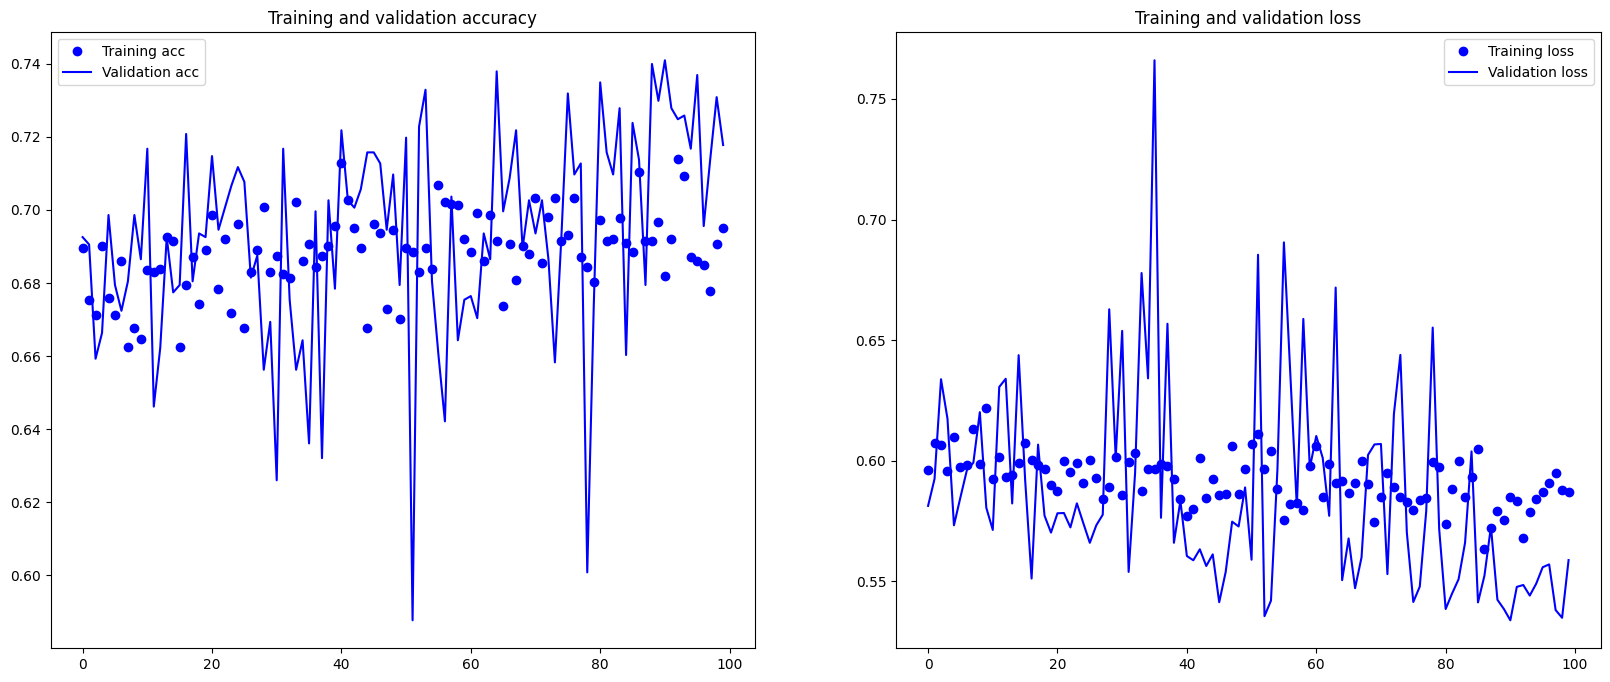

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Plot the ROC curves

In [ ]:
def find_labels_and_probability(img_gen):
  y_true = img_gen.classes

  # Get predicted probabilities (y_score)
  y_pred = model.predict(img_gen)

  return y_true, y_pred

test_y_true, test_probs = find_labels_and_probability(test_generator)

32/32 [==============================] - 2s 49ms/step


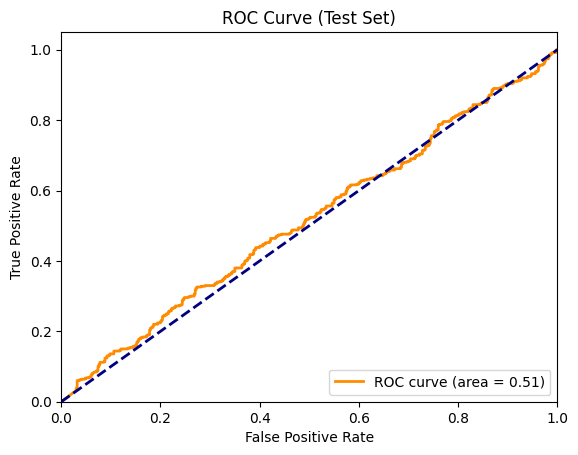

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curves for training, validation, and test sets
plot_roc_curve(test_y_true, test_probs, title='ROC Curve (Test Set)')

### Plot the Recall-Precision curves

In [ ]:
# Compute precision and recall for each dataset
test_precision, test_recall, threshold = precision_recall_curve(test_y_true, test_probs)

# Compute average precision (AUC-PR) for each dataset
test_average_precision = average_precision_score(test_y_true, test_probs)

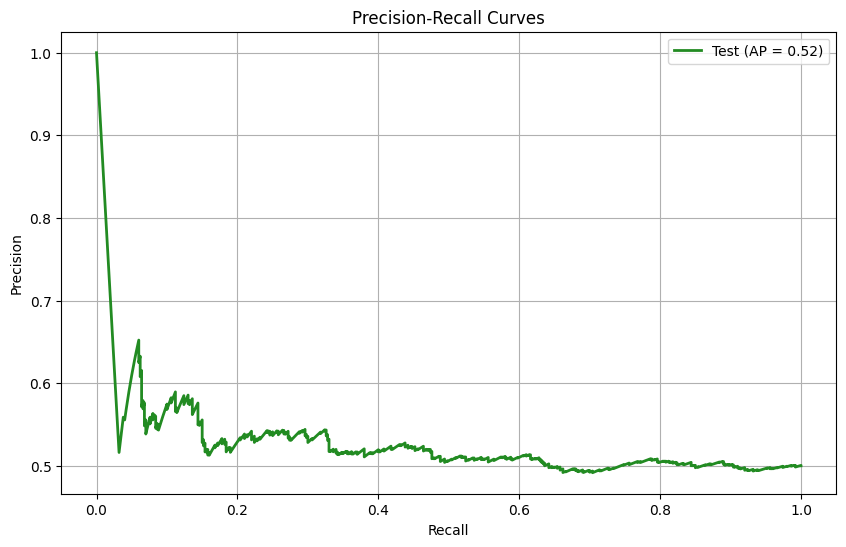

In [ ]:
# Plot Precision-Recall curves for all datasets
plt.figure(figsize=(10, 6))
# plt.plot(train_recall, train_precision, color='darkorange', lw=2, label=f'Training (AP = {train_average_precision:.2f})')
# plt.plot(val_recall, val_precision, color='royalblue', lw=2, label=f'Validation (AP = {val_average_precision:.2f})')
plt.plot(test_recall, test_precision, color='forestgreen', lw=2, label=f'Test (AP = {test_average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Confusion matrix for 50% threshold

Confusion Matrix Test Data (Threshold = 50%):
[[198 302]
 [188 312]]


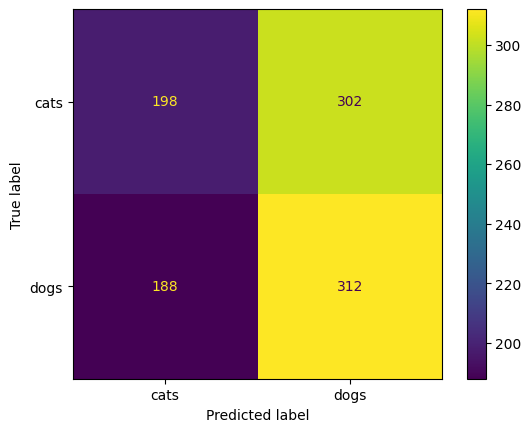

In [ ]:
def find_labels_and_probability(y_true, y_probs):
  threshold = 0.5
  # Convert probabilities to binary classes using the 50% threshold
  y_pred = (y_probs >= threshold).astype(int)  # Predicted classes (0 or 1)

  # Create the confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  return conf_matrix

test_conf_matrix = find_labels_and_probability(test_y_true, test_probs)

# Print the confusion matrix
print("Confusion Matrix Test Data (Threshold = 50%):")
print(test_conf_matrix)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=test_generator.class_indices)
disp.plot(cmap='viridis', values_format='d')

# Data Preprocessing


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers

In [ ]:
# Data Augmentation -  tuned with hyperparameters
# train_datagen_tuned = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=best_rotation_range,
#     width_shift_range=best_width_shift_range,
#     height_shift_range=best_height_shift_range,
#     shear_range=best_shear_range,
#     zoom_range=best_zoom_range,
#     horizontal_flip=best_horizontal_flip)

baseline_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation & test data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## 10% of the rare class (cats) and 100% of the common class (dogs).

In [ ]:
# Unzip file
!mkdir -p dogscats/data
!unzip -o -q dogs-vs-cats-10-per-rare.zip -d dogscats


In [ ]:
base_dir10 = 'dogscats/data'
train_dir10 = os.path.join(base_dir10, 'train')
train_cats_dir10 = os.path.join(base_dir10, 'train', 'cats')
train_dogs_dir10 = os.path.join(base_dir10, 'train', 'dogs')
validation_dir10 = os.path.join(base_dir10, 'validation')
test_dir10 = os.path.join(base_dir10, 'test')

### Baseline Data Augmentation

In [ ]:
best_batch_size = 32

In [ ]:
train10_generator = baseline_datagen.flow_from_directory(
        # This is the target directory
        train_dir10,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=best_batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation10_generator = validation_datagen.flow_from_directory(
        validation_dir10,
        target_size=(150, 150),
        batch_size=best_batch_size,
        class_mode='binary')

test10_generator = test_datagen.flow_from_directory(
        test_dir10,
        target_size=(150, 150),
        batch_size=best_batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 1% of the rare class (cats) and 100% of the common class (dogs).

In [ ]:
# shutil.rmtree('/content/dogscats/data1')

In [ ]:
# Unzip file
!mkdir -p dogscats/data1
!unzip -o -q dogs-vs-cats-1-per-rare.zip -d dogscats

In [ ]:
base_dir1 = 'dogscats/data1'
train_dir1 = os.path.join(base_dir1, 'train')
train_cats_dir1 = os.path.join(base_dir1, 'train', 'cats')
train_dogs_dir1 = os.path.join(base_dir1, 'train', 'dogs')
validation_dir1 = os.path.join(base_dir1, 'validation')
test_dir1 = os.path.join(base_dir1, 'test')

### Baseline Data Augmentation

In [ ]:
best_batch_size=32

In [ ]:
train1_generator = baseline_datagen.flow_from_directory(
        # This is the target directory
        train_dir1,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=best_batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation1_generator = validation_datagen.flow_from_directory(
        validation_dir1,
        target_size=(150, 150),
        batch_size=best_batch_size,
        class_mode='binary')

test1_generator = test_datagen.flow_from_directory(
        test_dir1,
        target_size=(150, 150),
        batch_size=best_batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Re-train the model

In [ ]:
from keras import layers, losses, optimizers, metrics
from sklearn.utils import class_weight

In [ ]:
def build_cnn_model_new_dataset():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-4),
                metrics=['acc'])

  return model

## 10% rare class datasets and evaluate

### Retrain and Revaluate

In [ ]:
# model10 = build_cnn_dog_cat_model(learning_rate, num_filters, dropout_rate, batch_size)
# model = model.load("/content/cats_and_dogs_best_tuned_model_1.h5")
# model = model.load("cats_and_dogs_best_tuned_model_1.h5")
model10 = build_cnn_model_new_dataset()
# model10 = build_cnn_dog_cat_model(best_learning_rate, best_num_filters,
#                                   best_dropout_rate, best_batch_size)

## Possibly the above might be to load the Baseline model instead of the optuna tuned

history10 = model10.fit(
      train10_generator,
      steps_per_epoch=2000//train10_generator.batch_size,
      epochs=20,
      validation_data=validation10_generator,
      validation_steps=1000//validation10_generator.batch_size)


Epoch 1/20
62/62 [==============================] - 70s 1s/step - loss: 5.6279 - acc: 0.8765 - val_loss: 0.6890 - val_acc: 0.8992
Epoch 2/20
62/62 [==============================] - 69s 1s/step - loss: 0.4011 - acc: 0.9014 - val_loss: 0.6781 - val_acc: 0.8992
Epoch 3/20
62/62 [==============================] - 68s 1s/step - loss: 0.4493 - acc: 0.9004 - val_loss: 0.6689 - val_acc: 0.8992
Epoch 4/20
62/62 [==============================] - 68s 1s/step - loss: 0.3600 - acc: 0.8994 - val_loss: 0.6619 - val_acc: 0.8992
Epoch 5/20
62/62 [==============================] - 68s 1s/step - loss: 0.3825 - acc: 0.8999 - val_loss: 0.6599 - val_acc: 0.9002
Epoch 6/20
62/62 [==============================] - 68s 1s/step - loss: 0.3790 - acc: 0.8994 - val_loss: 0.6487 - val_acc: 0.9002
Epoch 7/20
62/62 [==============================] - 69s 1s/step - loss: 0.3598 - acc: 0.9009 - val_loss: 0.6378 - val_acc: 0.8992
Epoch 8/20
62/62 [==============================] - 80s 1s/step - loss: 0.3468 - acc: 0.89

NameError: ignored

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model10.evaluate(validation10_generator, steps=len(validation10_generator))

32/32 [==============================] - 10s 296ms/step - loss: 0.6134 - acc: 0.9000


Accuracy on validation data is obtained 90% with baseline

In [ ]:
# model.save('cats_and_dogs_small10_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plot the loss and accuracy
of the model over the training and validation data during training:

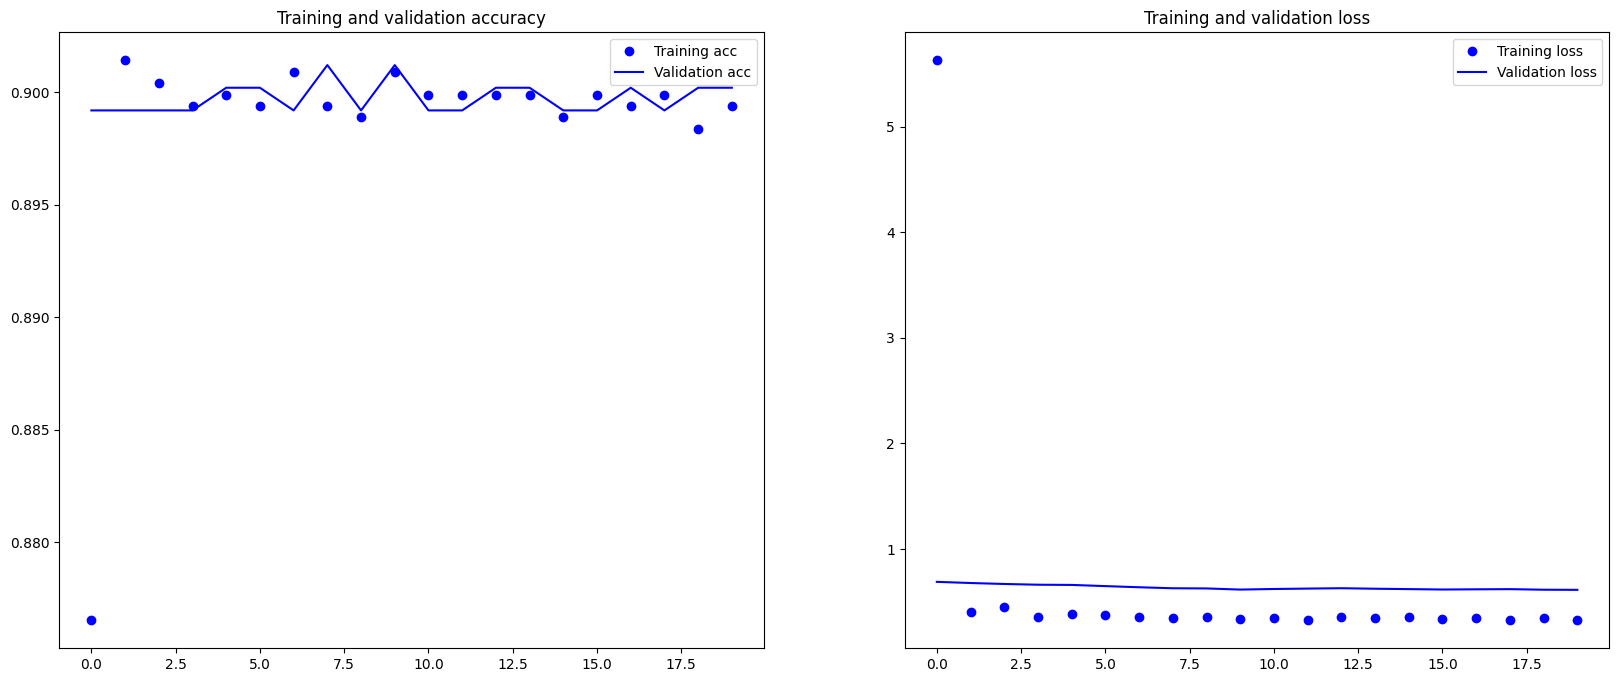

In [ ]:
import matplotlib.pyplot as plt

acc = history10.history['acc']
val_acc = history10.history['val_acc']
loss = history10.history['loss']
val_loss = history10.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data
augmentation*.

### Plot the ROC curves

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
def find_labels_and_probability(img_gen):
  y_true = img_gen.classes

  # Get predicted probabilities (y_score)
  y_pred = model10.predict(img_gen)

  return y_true, y_pred

test_y_true, test_probs = find_labels_and_probability(test10_generator)

32/32 [==============================] - 9s 290ms/step


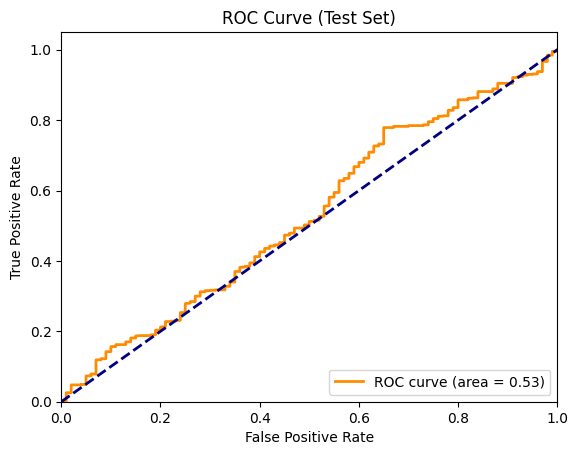

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curves for test sets
plot_roc_curve(test_y_true, test_probs, title='ROC Curve (Test Set)')

### Plot the Recall-Precision curves

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
# Compute precision and recall for each dataset
test_precision, test_recall, threshold = precision_recall_curve(test_y_true, test_probs)

# Compute average precision (AUC-PR) for each dataset
test_average_precision = average_precision_score(test_y_true, test_probs)

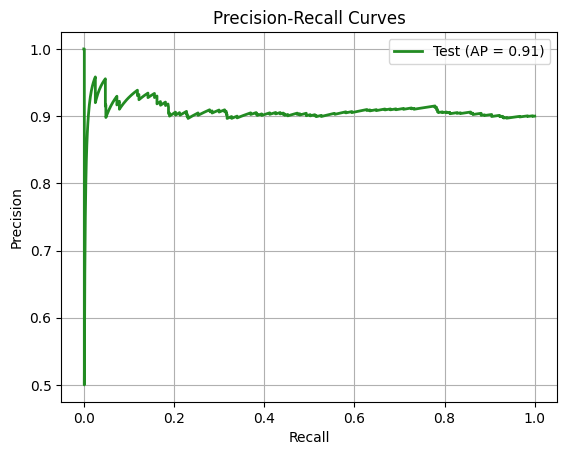

In [ ]:
# Plot Precision-Recall curves for all datasets
# plt.figure(figsize=(10, 6))
plt.figure()
plt.plot(test_recall, test_precision, color='forestgreen', lw=2, label=f'Test (AP = {test_average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Confusion matrix for 50% threshold

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Confusion Matrix Test Data (Threshold = 50%):
[[  0 100]
 [  0 900]]


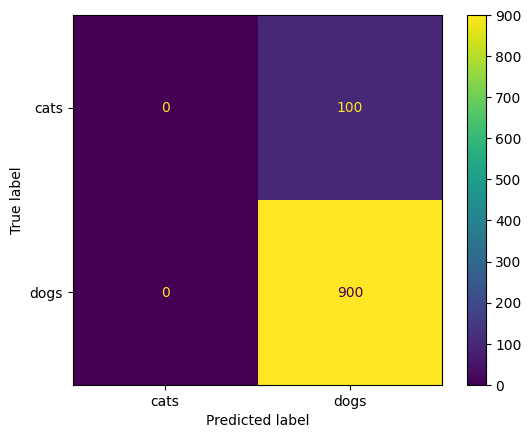

In [ ]:
def find_labels_and_probability(y_true, y_probs):
  threshold = 0.5
  # Convert probabilities to binary classes using the 50% threshold
  y_pred = (y_probs >= threshold).astype(int)  # Predicted classes (0 or 1)

  # Create the confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  return conf_matrix

# val_conf_matrix = find_labels_and_probability(val_y_true, val_probs)
test_conf_matrix = find_labels_and_probability(test_y_true, test_probs)

# Print the confusion matrix
print("Confusion Matrix Test Data (Threshold = 50%):")
print(test_conf_matrix)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=test10_generator.class_indices)
disp.plot(cmap='viridis', values_format='d')

# print("Confusion Matrix Validation Data (Threshold = 50%):")
# print(val_conf_matrix)

### Comment on what is the performance of the 10% rare class

## 1% rare class datasets and evaluate

### Retrain and reevaluate

In [ ]:
# model1 = build_cnn_dog_cat_model(learning_rate, num_filters, dropout_rate, batch_size)
# model1 = model.load("/content/cats_and_dogs_best_tuned_model_1.h5")
# model1 = build_cnn_CSL_model(best_learning_rate, best_num_filters,
#                                 best_dropout_rate, best_batch_size, class_weights)
model1 = build_cnn_model_new_dataset()

history1 = model1.fit(
      train1_generator,
      steps_per_epoch=2000//train1_generator.batch_size,
      epochs=20,
      validation_data=validation1_generator,
      validation_steps=1000//validation1_generator.batch_size)

# Evaluate the model on the validation set
val_loss, val_acc = model1.evaluate(validation1_generator, steps=len(validation1_generator))


Epoch 1/20
62/62 [==============================] - 84s 1s/step - loss: 3.3400 - acc: 0.9690 - val_loss: 0.6860 - val_acc: 0.9899
Epoch 2/20
62/62 [==============================] - 71s 1s/step - loss: 0.1354 - acc: 0.9903 - val_loss: 0.6615 - val_acc: 0.9899
Epoch 3/20
62/62 [==============================] - 72s 1s/step - loss: 0.1977 - acc: 0.9898 - val_loss: 0.6524 - val_acc: 0.9899
Epoch 4/20
62/62 [==============================] - 70s 1s/step - loss: 0.1130 - acc: 0.9898 - val_loss: 0.6553 - val_acc: 0.9899
Epoch 5/20
62/62 [==============================] - 70s 1s/step - loss: 0.1147 - acc: 0.9898 - val_loss: 0.6198 - val_acc: 0.9909
Epoch 6/20
62/62 [==============================] - 71s 1s/step - loss: 0.0933 - acc: 0.9898 - val_loss: 0.5864 - val_acc: 0.9899
Epoch 7/20
62/62 [==============================] - 69s 1s/step - loss: 0.0871 - acc: 0.9903 - val_loss: 0.6048 - val_acc: 0.9899
Epoch 8/20
62/62 [==============================] - 69s 1s/step - loss: 0.0912 - acc: 0.99

### Plot the loss and accuracy
of the model over the training and validation data during training:

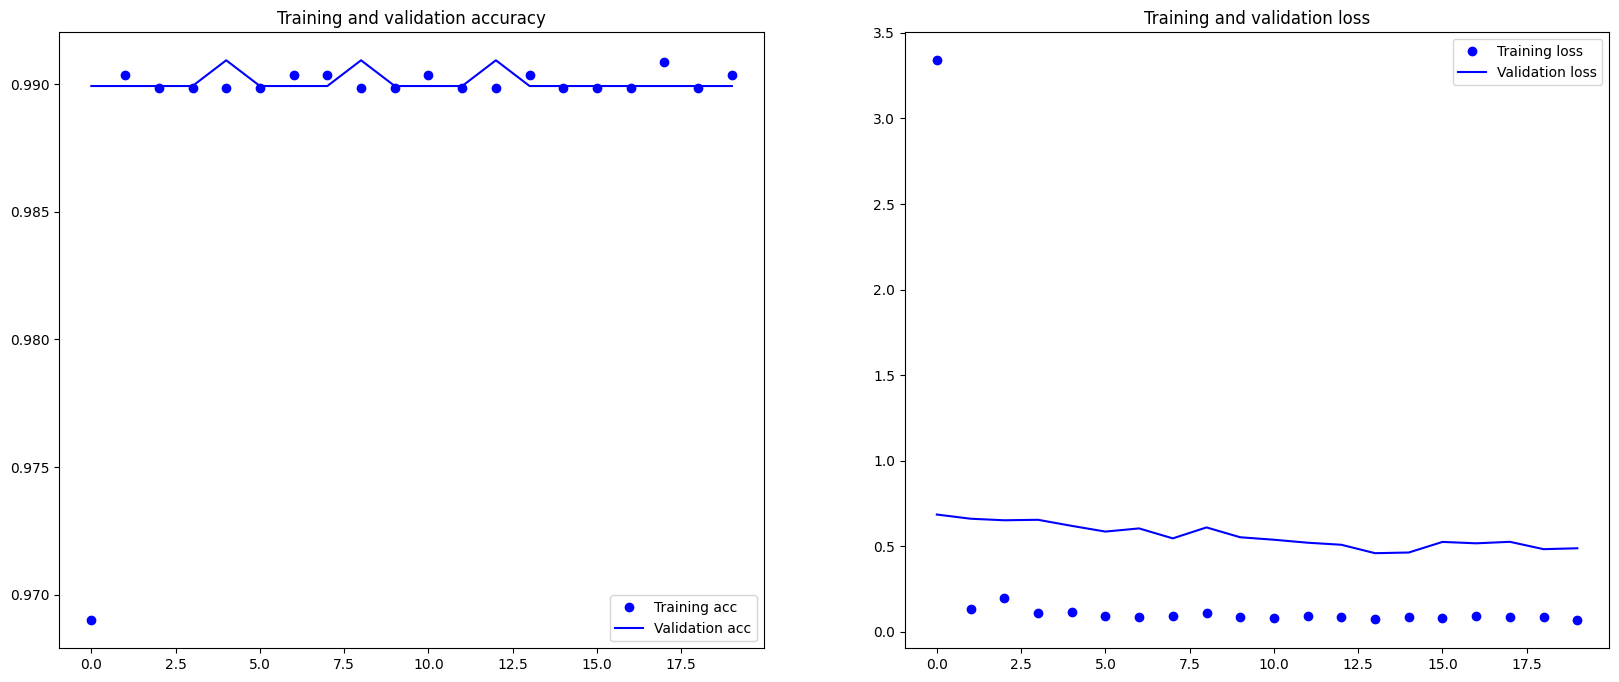

In [ ]:
import matplotlib.pyplot as plt

acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Plot the ROC curves

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
def find_labels_and_probability(img_gen):
  y_true = img_gen.classes

  # Get predicted probabilities (y_score)
  y_pred = model1.predict(img_gen)

  return y_true, y_pred

test_y_true, test_probs = find_labels_and_probability(test1_generator)

32/32 [==============================] - 9s 268ms/step


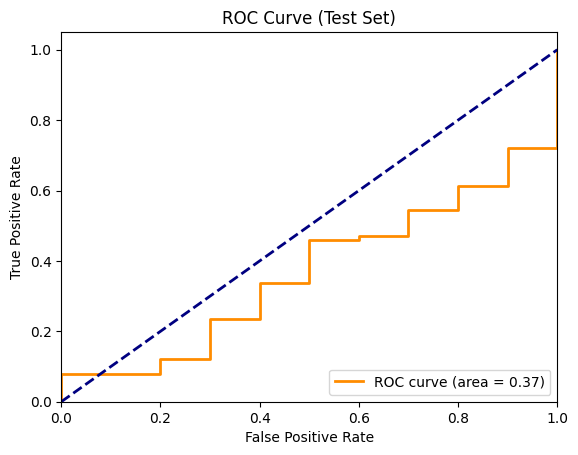

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curves for training, validation, and test sets
# plot_roc_curve(train_y_true, train_probs, title='ROC Curve (Training Set)')
# plot_roc_curve(val_y_true, val_probs, title='ROC Curve (Validation Set)')
plot_roc_curve(test_y_true, test_probs, title='ROC Curve (Test Set)')

### Plot the Recall-Precision curves

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
# Compute precision and recall for each dataset
# train_precision, train_recall, threshold = precision_recall_curve(train_y_true, train_probs)
# val_precision, val_recall, threshold = precision_recall_curve(val_y_true, val_probs)
test_precision, test_recall, threshold = precision_recall_curve(test_y_true, test_probs)

# Compute average precision (AUC-PR) for each dataset
# train_average_precision = average_precision_score(train_y_true, train_probs)
# val_average_precision = average_precision_score(val_y_true, val_probs)
test_average_precision = average_precision_score(test_y_true, test_probs)

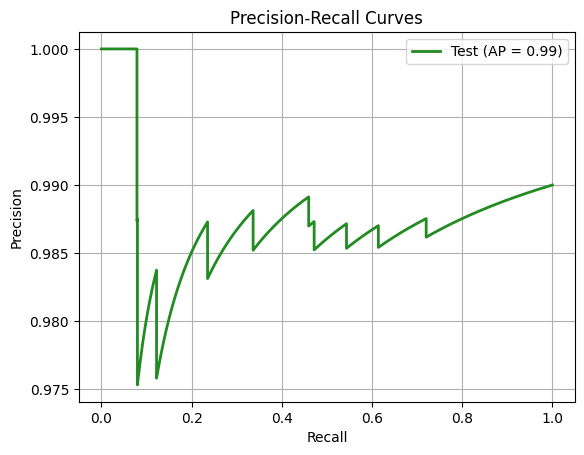

In [ ]:
# Plot Precision-Recall curves for all datasets
# plt.figure(figsize=(10, 6))
# plt.plot(train_recall, train_precision, color='darkorange', lw=2, label=f'Training (AP = {train_average_precision:.2f})')
# plt.plot(val_recall, val_precision, color='royalblue', lw=2, label=f'Validation (AP = {val_average_precision:.2f})')
plt.figure()
plt.plot(test_recall, test_precision, color='forestgreen', lw=2, label=f'Test (AP = {test_average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Confusion matrix for 50% threshold

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Confusion Matrix Test Data (Threshold = 50%):
[[ 38  62]
 [376 524]]


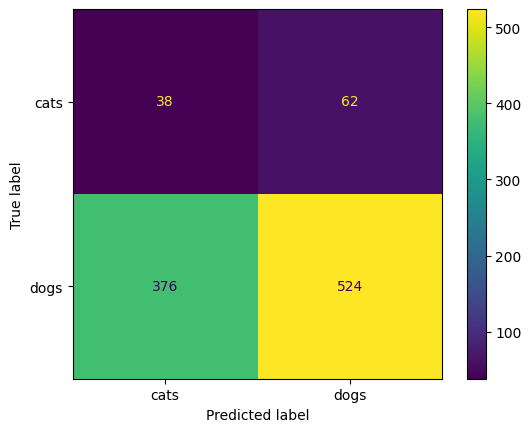

In [77]:
def find_labels_and_probability(y_true, y_probs):
  threshold = 0.99
  # Convert probabilities to binary classes using the 50% threshold
  y_pred = (y_probs >= threshold).astype(int)  # Predicted classes (0 or 1)

  # Create the confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  return conf_matrix

# val_conf_matrix = find_labels_and_probability(val_y_true, val_probs)
test_conf_matrix = find_labels_and_probability(test_y_true, test_probs)

# Print the confusion matrix
print("Confusion Matrix Test Data (Threshold = 50%):")
print(test_conf_matrix)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=test1_generator.class_indices)
disp.plot(cmap='viridis', values_format='d')

# print("Confusion Matrix Validation Data (Threshold = 50%):")
# print(val_conf_matrix)

### Comment on what is the performance of the 1% rare class

# Improve

![NOTE]: As discussed the following model is taking too much time so , training on the previous simpler model for faster results

In [ ]:
# def build_cnn_CSL_model(learning_rate, num_filters,
#                             dropout_rate, batch_size, class_weights):
#   model = keras.Sequential()

#   model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', input_shape=(150, 150, 3)))
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(layers.Conv2D(num_filters * 2, (3, 3), activation='relu'))
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(layers.Conv2D(num_filters * 4, (3, 3), activation='relu'))
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(layers.Conv2D(num_filters * 4, (3, 3), activation='relu'))
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(layers.Flatten())
#   model.add(layers.Dropout(dropout_rate))
#   model.add(layers.Dense(512, activation='relu'))
#   model.add(layers.Dense(1, activation='sigmoid'))

#   # Define your custom loss function with class-sensitive re-weighting
#   def class_sensitive_loss(class_weights):
#       def loss(y_true, y_pred):
#           weighted_loss = tf.keras.losses.binary_crossentropy(test_y_true, test_y_pred,
#                                                               from_logits=False) * class_weights
#           return tf.reduce_mean(weighted_loss)

#       return loss

#   # Compile the model with your custom loss function
#   model.compile(loss=class_sensitive_loss(class_weights),
#                 optimizer=optimizers.RMSprop(lr=learning_rate),
#                 metrics=['acc'])

#   return model



## 10% rare class dataset

### Using DataAugmentation

Tweaking the augmentation values further and adding more settings to strike a balance between the 2 datasets


In [ ]:
moderate_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,  # Reduce rotation range
    shear_range=0.1,  # Reduce shear range
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # Adjust brightness levels moderately
    channel_shift_range=0.1,  # Apply slight color channel shifts
    # contrast_stretching_range=[0.9, 1.1],  # Adjust contrast moderately
    vertical_flip=True,  # Flip vertically
    height_shift_range=0.05,  # Reduce height shift range further
    width_shift_range=0.05,  # Reduce width shift range further
    zoom_range=[0.95, 1.05],  # Reduce zoom range further
)

In [ ]:
train2_generator = moderate_datagen.flow_from_directory(
        # This is the target directory
        train_dir10,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=30,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation2_generator = validation_datagen.flow_from_directory(
        validation_dir10,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary')

test2_generator = test_datagen.flow_from_directory(
        test_dir10,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Using Class-sensitiveLearning



In [ ]:
train_labels = train2_generator.labels

# Step 1: Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Convert class weights to a dictionary for easy use in Keras
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

reverse_class_weights_dict = {cls: 1.0 / weight for cls, weight in class_weights_dict.items()}

# Print or use the class weights as needed
print("Class Weights:", class_weights_dict)
print("reverse Class Weights:", reverse_class_weights_dict)

Class Weights: {0: 5.0, 1: 0.5555555555555556}
reverse Class Weights: {0: 0.2, 1: 1.7999999999999998}


### Retrain the model

In [ ]:
# Build and train your model on the balanced dataset with class-sensitive learning
model = build_cnn_model_new_dataset()

# Train the model
history2 = model.fit(
      train2_generator,
      steps_per_epoch=2000//train2_generator.batch_size,
      epochs=20,
      validation_data=validation2_generator,
      validation_steps=1000//validation2_generator.batch_size,
      class_weight=reverse_class_weights_dict)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation2_generator, steps=len(validation2_generator))

Epoch 1/20
66/66 [==============================] - 74s 1s/step - loss: 0.1575 - acc: 0.8858 - val_loss: 0.3690 - val_acc: 0.8990
Epoch 2/20
66/66 [==============================] - 72s 1s/step - loss: 0.1170 - acc: 0.8995 - val_loss: 0.4404 - val_acc: 0.9000
Epoch 3/20
66/66 [==============================] - 71s 1s/step - loss: 0.1123 - acc: 0.8990 - val_loss: 0.4140 - val_acc: 0.9000
Epoch 4/20
66/66 [==============================] - 71s 1s/step - loss: 0.1106 - acc: 0.9005 - val_loss: 0.4748 - val_acc: 0.9000
Epoch 5/20
66/66 [==============================] - 71s 1s/step - loss: 0.1101 - acc: 0.9005 - val_loss: 0.4582 - val_acc: 0.9020
Epoch 6/20
66/66 [==============================] - 72s 1s/step - loss: 0.1091 - acc: 0.9000 - val_loss: 0.4232 - val_acc: 0.9000
Epoch 7/20
66/66 [==============================] - 72s 1s/step - loss: 0.1088 - acc: 0.9005 - val_loss: 0.4682 - val_acc: 0.9010
Epoch 8/20
66/66 [==============================] - 73s 1s/step - loss: 0.1078 - acc: 0.90

### Plot the loss and accuracy
of the model over the training and validation data during training:

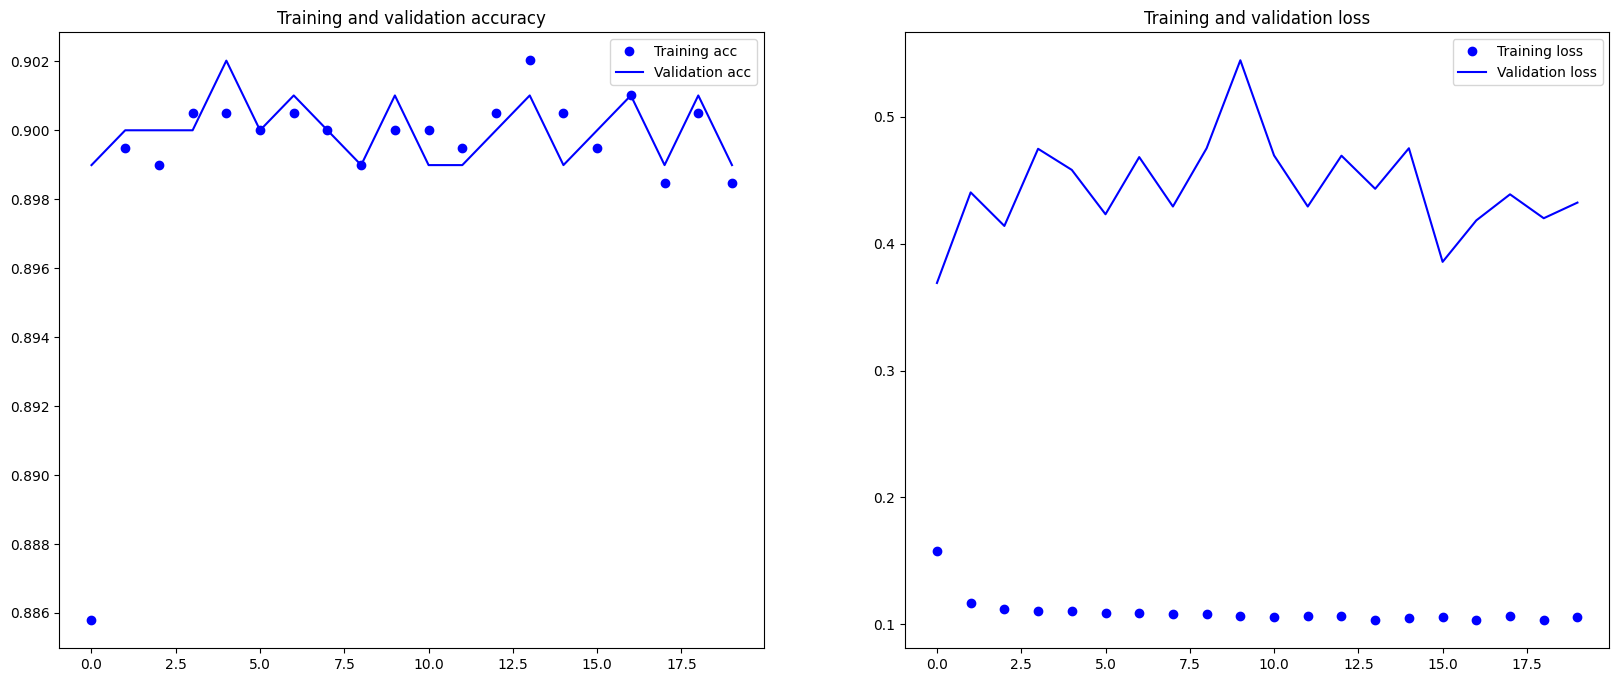

In [50]:
import matplotlib.pyplot as plt

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Plot the ROC curves

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [52]:
def find_labels_and_probability(img_gen):
  y_true = img_gen.classes

  # Get predicted probabilities (y_score)
  y_pred = model.predict(img_gen)

  return y_true, y_pred

test_y_true, test_probs = find_labels_and_probability(test2_generator)

34/34 [==============================] - 9s 264ms/step


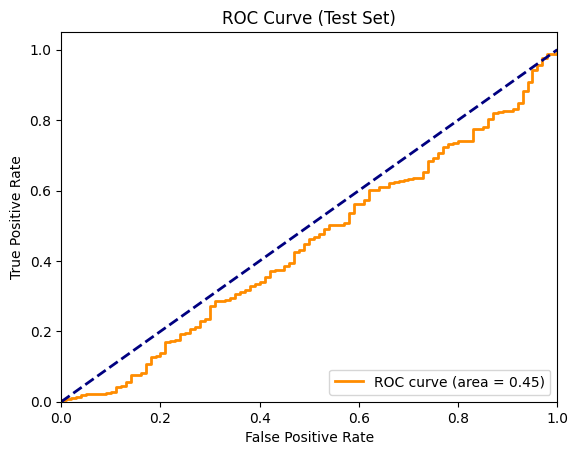

In [53]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curves for training, validation, and test sets
# plot_roc_curve(train_y_true, train_probs, title='ROC Curve (Training Set)')
# plot_roc_curve(val_y_true, val_probs, title='ROC Curve (Validation Set)')
plot_roc_curve(test_y_true, test_probs, title='ROC Curve (Test Set)')

### Plot the Recall-Precision curves

In [54]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [55]:
# Compute precision and recall for each dataset
# train_precision, train_recall, threshold = precision_recall_curve(train_y_true, train_probs)
# val_precision, val_recall, threshold = precision_recall_curve(val_y_true, val_probs)
test_precision, test_recall, threshold = precision_recall_curve(test_y_true, test_probs)

# Compute average precision (AUC-PR) for each dataset
# train_average_precision = average_precision_score(train_y_true, train_probs)
# val_average_precision = average_precision_score(val_y_true, val_probs)
test_average_precision = average_precision_score(test_y_true, test_probs)

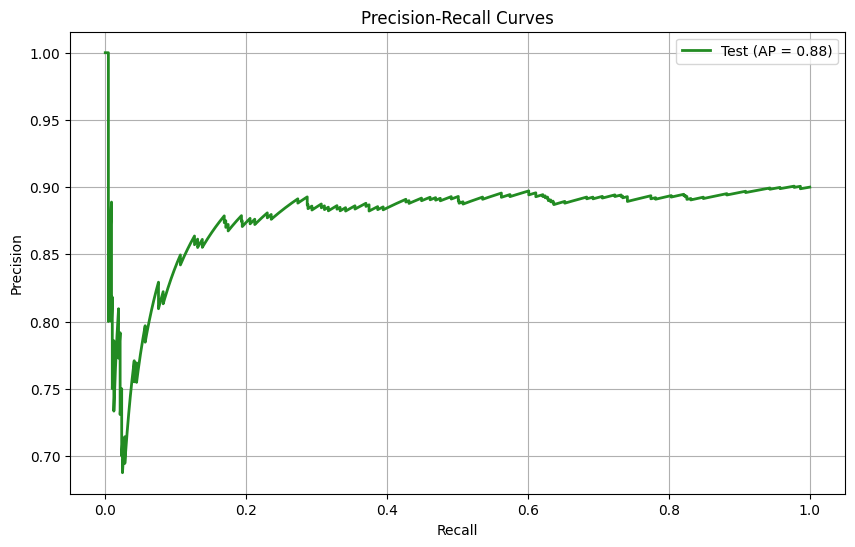

In [56]:
# Plot Precision-Recall curves for all datasets
plt.figure(figsize=(10, 6))
# plt.plot(train_recall, train_precision, color='darkorange', lw=2, label=f'Training (AP = {train_average_precision:.2f})')
# plt.plot(val_recall, val_precision, color='royalblue', lw=2, label=f'Validation (AP = {val_average_precision:.2f})')
plt.plot(test_recall, test_precision, color='forestgreen', lw=2, label=f'Test (AP = {test_average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Confusion matrix for 50% threshold

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Confusion Matrix Test Data (Threshold = 50%):
[[ 32  68]
 [337 563]]


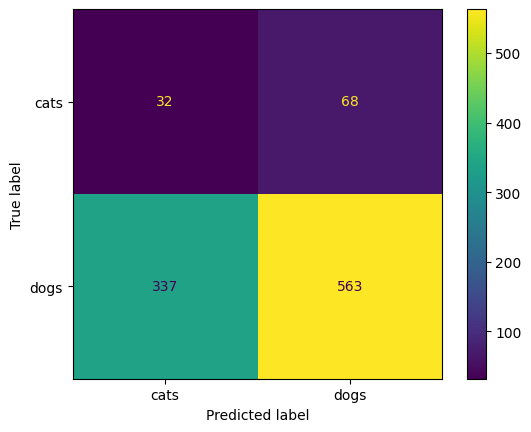

In [73]:
def find_labels_and_probability(y_true, y_probs):
  threshold = 0.98889
  # Convert probabilities to binary classes using the 50% threshold
  y_pred = (y_probs >= threshold).astype(int)  # Predicted classes (0 or 1)

  # Create the confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  return conf_matrix

# val_conf_matrix = find_labels_and_probability(val_y_true, val_probs)
test_conf_matrix = find_labels_and_probability(test_y_true, test_probs)

# Print the confusion matrix
print("Confusion Matrix Test Data (Threshold = 50%):")
print(test_conf_matrix)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=test2_generator.class_indices)
disp.plot(cmap='viridis', values_format='d')

# print("Confusion Matrix Validation Data (Threshold = 50%):")
# print(val_conf_matrix)

## 1% rare class dataset

### Using DataAugmentation

Tweaking the augmentation values further and adding more settings to strike a balance between the 2 datasets


In [80]:
agrresive_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],  # Adjust brightness levels
    channel_shift_range=0.2,  # Randomly shift color channels
    zoom_range=[0.8, 1.2],  # Randomly zoom in or out
    vertical_flip=True,  # Flip vertically
    featurewise_center=True,  # Apply mean centering
    featurewise_std_normalization=True,  # Apply standardization
    zca_whitening=True,  # Apply ZCA whitening
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1451: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


In [81]:
train3_generator = agrresive_datagen.flow_from_directory(
        # This is the target directory
        train_dir1,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=30,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation3_generator = validation_datagen.flow_from_directory(
        validation_dir1,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary')

test3_generator = test_datagen.flow_from_directory(
        test_dir1,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Using Class-sensitiveLearning



In [82]:
train_labels = train3_generator.labels

# Step 1: Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Convert class weights to a dictionary for easy use in Keras
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

reverse_class_weights_dict = {cls: 1.0 / weight for cls, weight in class_weights_dict.items()}

# Print or use the class weights as needed
print("Class Weights:", class_weights_dict)
print("reverse Class Weights:", reverse_class_weights_dict)

Class Weights: {0: 50.0, 1: 0.5050505050505051}
reverse Class Weights: {0: 0.02, 1: 1.98}


### Retrain the model

In [83]:
# Build and train your model on the balanced dataset with class-sensitive learning
model = build_cnn_model_new_dataset()

# Train the model
history3 = model.fit(
      train3_generator,
      steps_per_epoch=2000//train3_generator.batch_size,
      epochs=20,
      validation_data=validation3_generator,
      validation_steps=1000//validation3_generator.batch_size,
      class_weight=reverse_class_weights_dict)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation3_generator, steps=len(validation3_generator))

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
66/66 [==============================] - 72s 1s/step - loss: 0.0227 - acc: 0.9868 - val_loss: 0.1562 - val_acc: 0.9899
Epoch 2/20
66/66 [==============================] - 73s 1s/step - loss: 0.0032 - acc: 0.9898 - val_loss: 0.0881 - val_acc: 0.9899
Epoch 3/20
66/66 [==============================] - 71s 1s/step - loss: 0.0026 - acc: 0.9898 - val_loss: 0.1148 - val_acc: 0.9899
Epoch 4/20
66/66 [==============================] - 76s 1s/step - loss: 0.0023 - acc: 0.9898 - val_loss: 0.1047 - val_acc: 0.9899
Epoch 5/20
66/66 [==============================] - 73s 1s/step - loss: 0.0023 - acc: 0.9898 - val_loss: 0.0961 - val_acc: 0.9899
Epoch 6/20
66/66 [==============================] - 74s 1s/step - loss: 0.0022 - acc: 0.9899 - val_loss: 0.1046 - val_acc: 0.9899
Epoch 7/20
66/66 [==============================] - 71s 1s/step - loss: 0.0022 - acc: 0.9898 - val_loss: 0.0992 - val_acc: 0.9899
Epoch 8/20
66/66 [==============================] - 71s 1s/step - loss: 0.0021 - acc: 0.98

### Plot the loss and accuracy
of the model over the training and validation data during training:

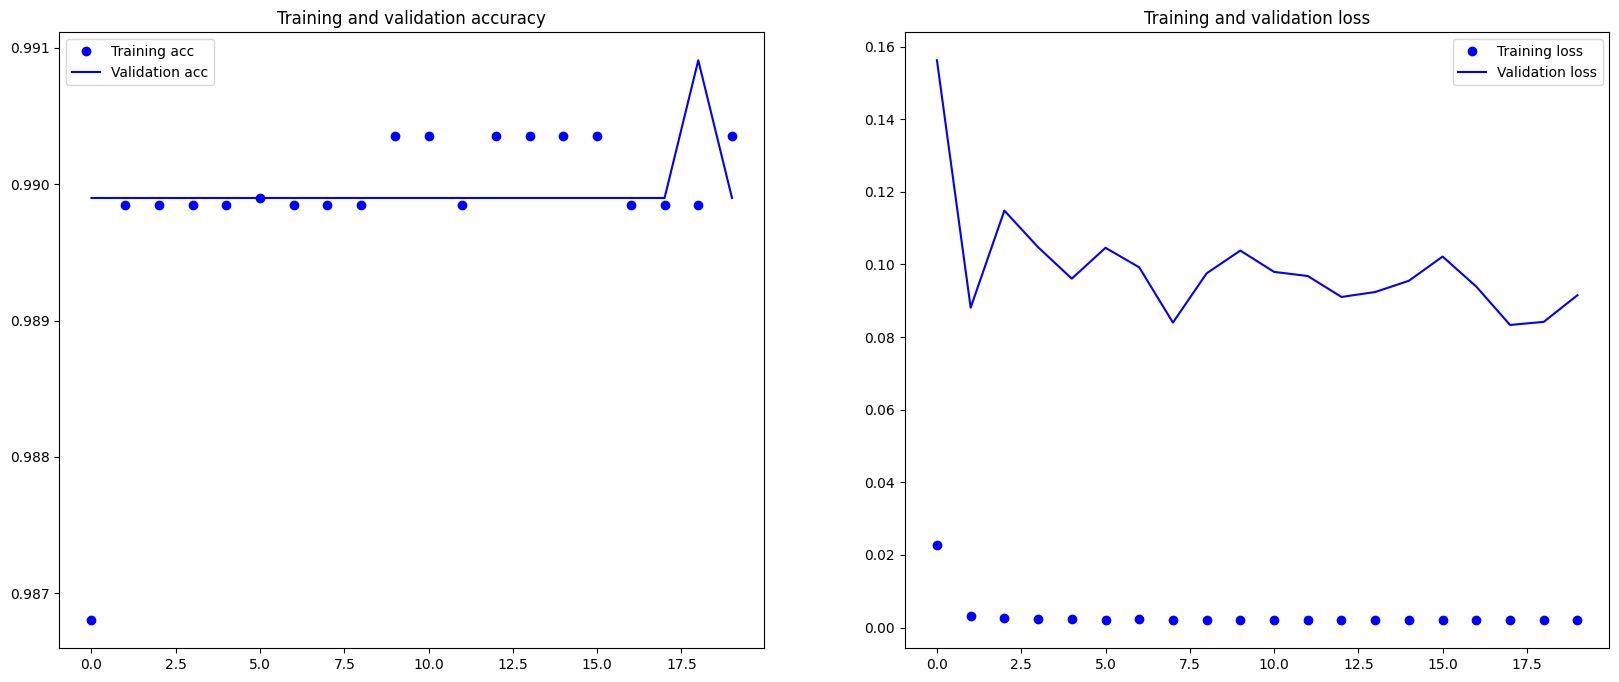

In [84]:
import matplotlib.pyplot as plt

acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Plot the ROC curves

In [85]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [86]:
def find_labels_and_probability(img_gen):
  y_true = img_gen.classes

  # Get predicted probabilities (y_score)
  y_pred = model.predict(img_gen)

  return y_true, y_pred

test_y_true, test_probs = find_labels_and_probability(test3_generator)

34/34 [==============================] - 9s 270ms/step


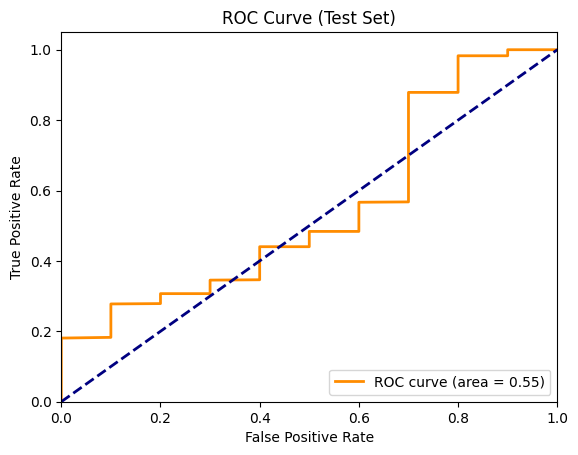

In [87]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curves for training, validation, and test sets
# plot_roc_curve(train_y_true, train_probs, title='ROC Curve (Training Set)')
# plot_roc_curve(val_y_true, val_probs, title='ROC Curve (Validation Set)')
plot_roc_curve(test_y_true, test_probs, title='ROC Curve (Test Set)')

True positive rate is much higher than false positive, with the usage of hyper parameter tuned model at the start of the Improve section in this notebook, this can be further improved

### Plot the Recall-Precision curves

In [88]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [89]:
# Compute precision and recall for each dataset
test_precision, test_recall, threshold = precision_recall_curve(test_y_true, test_probs)

# Compute average precision (AUC-PR) for each dataset
test_average_precision = average_precision_score(test_y_true, test_probs)

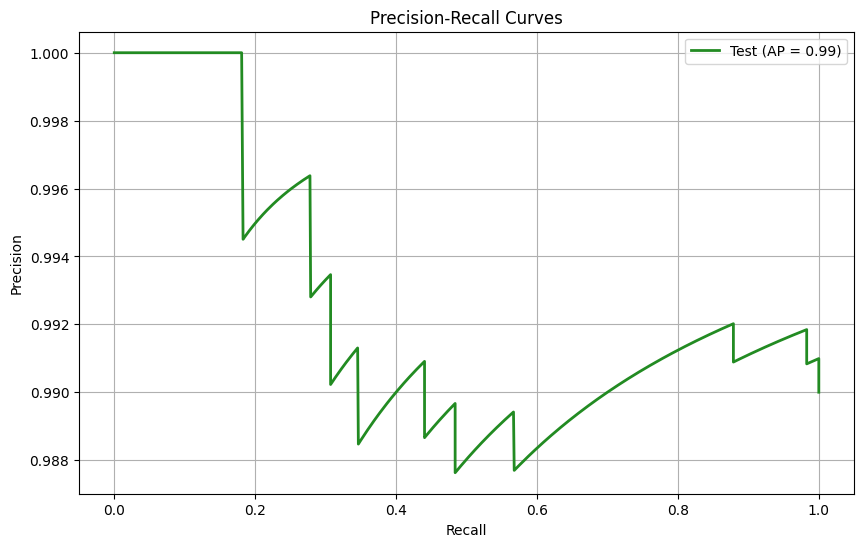

In [90]:
# Plot Precision-Recall curves for all datasets
plt.figure(figsize=(10, 6))
plt.plot(test_recall, test_precision, color='forestgreen', lw=2, label=f'Test (AP = {test_average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Confusion matrix for 50% threshold

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Confusion Matrix Test Data (Threshold = 50%):
[[  0  10]
 [  0 990]]


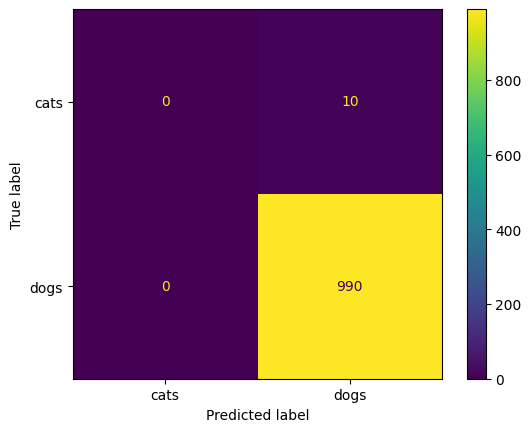

In [103]:
def find_labels_and_probability(y_true, y_probs):
  threshold = 0.5
  # Convert probabilities to binary classes using the 50% threshold
  y_pred = (y_probs >= threshold).astype(int)  # Predicted classes (0 or 1)

  # Create the confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  return conf_matrix

# val_conf_matrix = find_labels_and_probability(val_y_true, val_probs)
test_conf_matrix = find_labels_and_probability(test_y_true, test_probs)

# Print the confusion matrix
print("Confusion Matrix Test Data (Threshold = 50%):")
print(test_conf_matrix)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=test3_generator.class_indices)
disp.plot(cmap='viridis', values_format='d')

# print("Confusion Matrix Validation Data (Threshold = 50%):")
# print(val_conf_matrix)

# Observation

Although using class imbalances was handled and the overfitting was managed by aggressively augmenting the data on the rare class and by providing tweaking the weightage and alloting more weightage to the rare class, however, it could have been better if we will further train the model with the Best Hyperparameters obtained from optuna tunining like the best learning rate, and number of filters in the augmented data etc along with regularization and custom loss on class weights.  

[NOTE]: I have implemented the model for the hyperparameter and the above mentioned logic, but as discussed, due to GPU constraint , the model was running extremly slow so I am unable to use the hyperparameter tuned model in the Improve section and instead used a basic model.

Here, although we achieved ~98% accuracy, there is  overfitting that could have been lowered with the usage of the hyperparameter tuned model and further improving the accuracy for small amount of dataset.